# **Understanding Machine Learning Models - Regression segment**

Supervisor: Dr. Kovács Edith Alice \\

## **0. Installing and importing libraries**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import xgboost as xgb

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

import shap

import itertools

In [ ]:
!pip install sqlalchemy psycopg2
!conda install -y sqlalchemy psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: conda: command not found


## **1. Data loading**

In this segment we used the database directly to write SQL queries and load the needed data.

In [ ]:
from sqlalchemy import create_engine


POSTGRES_ADDRESS = 'o-o-o.hu' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'aragacs' 
POSTGRES_PASSWORD = '********'
POSTGRES_DBNAME = 'ooo'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

In [ ]:
all_statok = pd.read_sql_query(
    '''SELECT geoname, tstar.geonameid, label, tvalue, topicid 
       FROM tstar.tvalue AS tstar
       LEFT JOIN tstar.distinct_geoname AS geoname
	        ON tstar.geonameid=geoname.geonameid
       LEFT JOIN tstar.datatype AS ksh_name 
          ON tstar.topicid = ksh_name.tstarid
       WHERE tyear=2010
          AND topicid IN ('TAAA101', 'TAAR012', 'TAAS001', 'TAAS036', 'TAAT139', 'TAAH003', 'TAAT127', 'TAAH000', 'TAAH201', 'TAAH300', 'TAAH600', 'TAAP041', 'TAAC100', 'TAAO032', 'TAAP003', 'TAAT126','TAAR001');''', cnx)

In [ ]:
all_statok.fillna(0)

,geoname,geonameid,label,tvalue,topicid
0,Sarkadkeresztúr,10029.0,személygépkocsik száma,397,TAAR001
1,Rábcakapi,10041.0,személygépkocsik száma,64,TAAR001
2,Zánka,9880.0,személygépkocsik száma,359,TAAR001
3,0,0.0,háztartásoknak szolgáltatott víz mennyisége,0,TAAH000
4,Sénye,17411.0,személygépkocsik száma,23,TAAR001
...,...,...,...,...,...
53688,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600
53689,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600
53690,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600
53691,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600


In [ ]:
cross_all=pd.crosstab(all_statok.geoname, all_statok.label, values=all_statok.tvalue, aggfunc=lambda x: sum(x))

In [ ]:
cross_all = cross_all.rename(columns={'rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül) ': 'rendszeres szociális segélyben részesítettek átlagos száma'})
cross_all.head()

label,a helyi önkormányzatok saját folyó bevételei,a háztartások részére szolgáltatott villamosenergia mennyisége,egy éven túl nyilvántartott álláskeresők száma összesen,egyéni gazdaságok száma,háztartási gázfogyasztók száma,háztartásoknak szolgáltatott víz mennyisége,időskorúak járadékára felhasznált összeg,korlátolt felelősségű társaságok száma,kábeltelevízió előfizetőinek száma,lakónépesség száma az év végén,regisztrált munkanélküliek száma összesen,regisztrált vállalkozások száma,rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma,rendszeres szociális segélyben részesítettek átlagos száma,személygépkocsik száma,önkormányzati kiépített út és köztér hossza,üzemelő közkifolyók száma
geoname,,,,,,,,,,,,,,,,,
Aba,134265.0,4330.0,45.0,424.0,1227.0,125.0,844.0,68.0,599.0,4674.0,262.0,492.0,438.0,20.0,1060.0,15.0,2.0
Abaliget,14575.0,769.0,9.0,33.0,0.0,20.0,0.0,17.0,11.0,584.0,58.0,93.0,55.0,6.0,193.0,8.0,2.0
Abasár,217242.0,3448.0,47.0,306.0,875.0,82.0,325.0,58.0,418.0,2507.0,152.0,638.0,102.0,7.0,948.0,12.0,4.0
Abaújalpár,1313.0,57.0,6.0,22.0,19.0,1.0,0.0,5.0,0.0,75.0,19.0,14.0,9.0,2.0,21.0,4.0,6.0
Abaújkér,15995.0,601.0,21.0,87.0,119.0,13.0,0.0,8.0,50.0,697.0,80.0,67.0,122.0,8.0,115.0,12.0,34.0


In [ ]:
cross_all.columns

Index(['a helyi önkormányzatok saját folyó bevételei',
       'a háztartások részére szolgáltatott villamosenergia mennyisége',
       'egy éven túl nyilvántartott álláskeresők száma összesen',
       'egyéni gazdaságok száma', 'háztartási gázfogyasztók száma',
       'háztartásoknak szolgáltatott víz mennyisége',
       'időskorúak járadékára felhasznált összeg',
       'korlátolt felelősségű társaságok száma',
       'kábeltelevízió előfizetőinek száma', 'lakónépesség száma az év végén',
       'regisztrált munkanélküliek száma összesen',
       'regisztrált vállalkozások száma',
       'rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma',
       'rendszeres szociális segélyben részesítettek átlagos száma',
       'személygépkocsik száma', 'önkormányzati kiépített út és köztér hossza',
       'üzemelő közkifolyók száma'],
      dtype='object', name='label')

In [ ]:
div_features = list(cross_all.columns)
div_features.pop(-8)

'lakónépesség száma az év végén'

In terms of preprocessing, we selected 15 variables manually to build a model to predict the number of cars (per capita). Per capita since we also divided each variable with the population number for each settlement. 

In [ ]:
cross_all[div_features] = cross_all[div_features].div(cross_all['lakónépesség száma az év végén'],axis=0)
cross_all = cross_all[div_features]
cross_all.head()

label,a helyi önkormányzatok saját folyó bevételei,a háztartások részére szolgáltatott villamosenergia mennyisége,egy éven túl nyilvántartott álláskeresők száma összesen,egyéni gazdaságok száma,háztartási gázfogyasztók száma,háztartásoknak szolgáltatott víz mennyisége,időskorúak járadékára felhasznált összeg,korlátolt felelősségű társaságok száma,kábeltelevízió előfizetőinek száma,regisztrált munkanélküliek száma összesen,regisztrált vállalkozások száma,rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma,rendszeres szociális segélyben részesítettek átlagos száma,személygépkocsik száma,önkormányzati kiépített út és köztér hossza,üzemelő közkifolyók száma
geoname,,,,,,,,,,,,,,,,
Aba,28.725931,0.926401,0.009628,0.090715,0.262516,0.026744,0.180573,0.014549,0.128156,0.056055,0.105263,0.093710,0.004279,0.226786,0.003209,0.000428
Abaliget,24.957192,1.316781,0.015411,0.056507,0.000000,0.034247,0.000000,0.029110,0.018836,0.099315,0.159247,0.094178,0.010274,0.330479,0.013699,0.003425
Abasár,86.654168,1.375349,0.018748,0.122058,0.349023,0.032708,0.129637,0.023135,0.166733,0.060630,0.254487,0.040686,0.002792,0.378141,0.004787,0.001596
Abaújalpár,17.506667,0.760000,0.080000,0.293333,0.253333,0.013333,0.000000,0.066667,0.000000,0.253333,0.186667,0.120000,0.026667,0.280000,0.053333,0.080000
Abaújkér,22.948350,0.862267,0.030129,0.124821,0.170732,0.018651,0.000000,0.011478,0.071736,0.114778,0.096126,0.175036,0.011478,0.164993,0.017217,0.048780


In [ ]:
feature_names = list(cross_all.columns)
feature_names.pop(-3)

'személygépkocsik száma'

## **2. Training the model**

### 15 variables

We used an XGBoost model to predict the car number and from this model we can get the Shapley approximations, and visualizations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cross_all[feature_names], cross_all['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

[15:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

The first figure below shows the absolute value of global average importance, so we don't know yet in which direction these variables influence the prediction, but we know which ones are the most important.

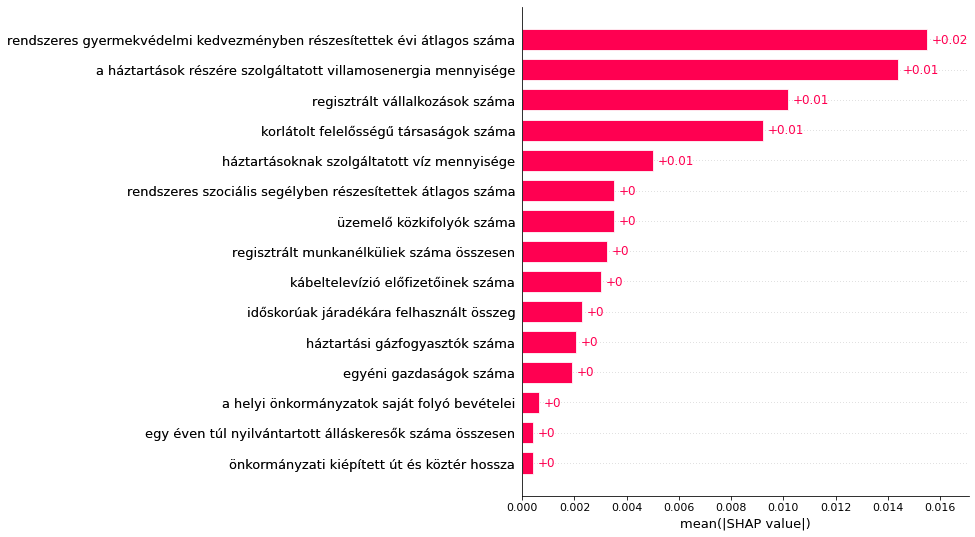

In [ ]:
shap.plots.bar(shap_values_xgb, max_display=15)

On the heatmap we can visualize 100 datapoints at the same time, these are represented by the really narrow columns. In the columns where the red/pink (high Shapley value) elements are in greater numbers, we have a larger prediction for the car number per capita (f(x) above the figure). Similarly for the blue elements just the other way around.

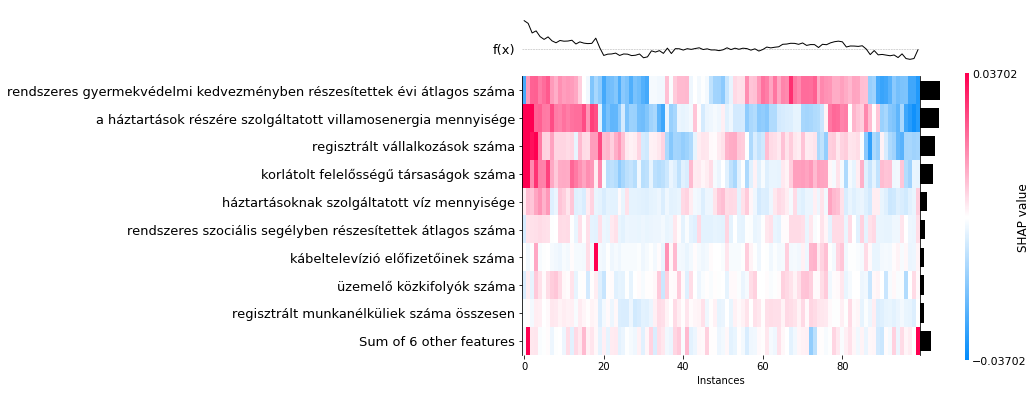

In [ ]:
shap.plots.heatmap(shap_values_xgb[100:200])

Here we have our first individual figure where we see the Shapley values for just one settlement. Now it's also visible into which direction the certain variables move the final prediction. The settlement in question is Üröm. The rest of the figures show the same numbers but give some variability in terms of visuals.

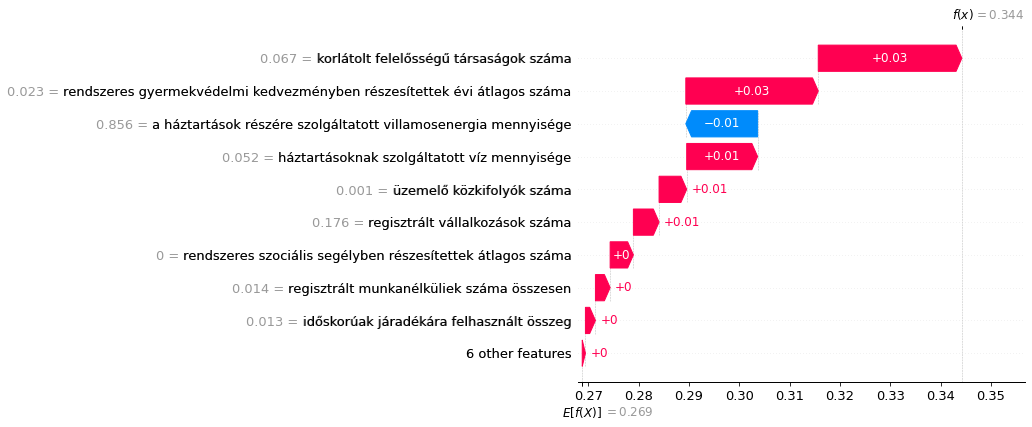

In [ ]:
shap.plots.waterfall(shap_values_xgb[0])

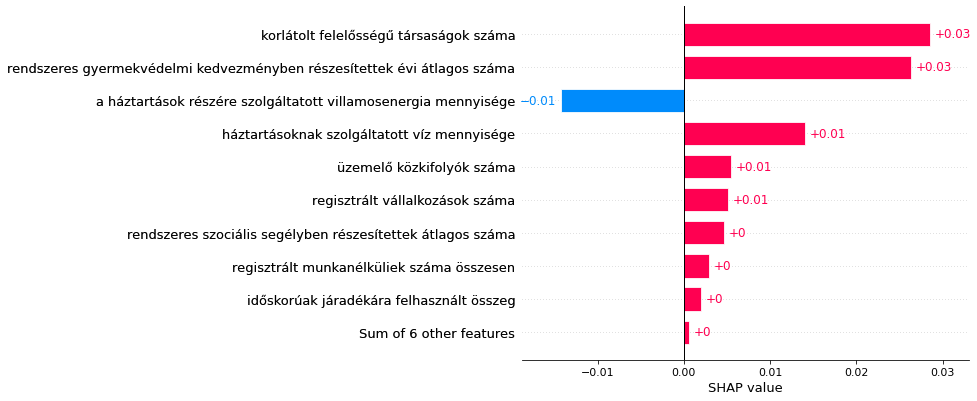

In [ ]:
shap.plots.bar(shap_values_xgb[0])

In [ ]:
shap.initjs()
explainer_tree = shap.TreeExplainer(xgb_model)
shap_values_tree = explainer_tree.shap_values(X_test)
def p(j):
    return(shap.force_plot(explainer_tree.expected_value, shap_values_tree[j,:], X_test.iloc[j,:]))
p(0)

The final prediction is  0.3442042


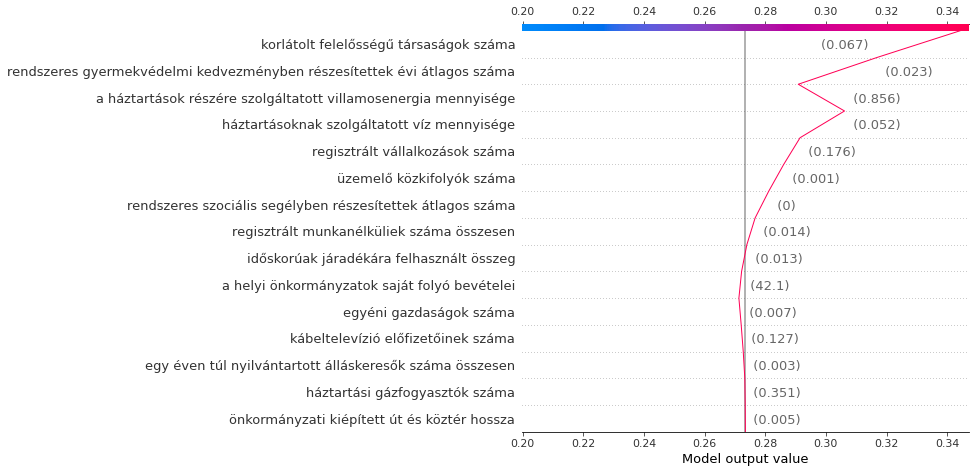

In [ ]:
expected_value = explainer_tree.expected_value
#print("The expected value is ", expected_value)
print("The final prediction is ", xgb_model.predict(X_test)[0])
shap_values_0 = explainer_tree.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values_0, X_test)

### 46 variables

We checked the results with a larger variable size and chose some that are pretty redundant. We found that most of the important variables remained the same as before, but there are new ones even from the redundant variables.

In [ ]:
sok_valt_statok = pd.read_sql_query(
    '''SELECT geoname, tstar.geonameid, label, tvalue, topicid 
       FROM tstar.tvalue AS tstar
       LEFT JOIN tstar.distinct_geoname AS geoname
	        ON tstar.geonameid=geoname.geonameid
       LEFT JOIN tstar.datatype AS ksh_name 
          ON tstar.topicid = ksh_name.tstarid
       WHERE tyear=2010
          AND topicid IN ('TAAA101', 'TAAR012', 'TAAS001', 'TAAS036', 'TAAT139', 'TAAH003', 'TAAT127', 'TAAH000', 'TAAH201', 'TAAH300', 'TAAH600', 'TAAP041', 'TAAC100', 'TAAO032', 'TAAP003', 'TAAT126','TAAR001',''
          ,'TAAB102','TAAB103','TAAC200','TAAF226','TAAF423','TAAG100','TAAH501','TAAH402','TAAH608','TAAJ425','TAAJ466','TAAJ428','TAAK142','TAAK246','TAAK229','TAAL603','TAAP022','TAAP801'
          ,'TAAR127','TAAS019','TAAT138','TAAX000','TAAX100','TAAP077','TAAL600','TAAJ313','TAAH501','TAAG132','TAAF444','TAAF071','TAAB000');''', cnx)

In [ ]:
sok_valt_statok.fillna(0)

,geoname,geonameid,label,tvalue,topicid
0,Cserépváralja,11127.0,közművelődési intézmények száma,0,TAAL600
1,Hernádszurdok,16533.0,közművelődési intézmények száma,0,TAAL600
2,Kány,16444.0,közművelődési intézmények száma,0,TAAL600
3,Berzék,11371.0,kulturális rendezvények száma,34,TAAL603
4,Sajólád,458.0,közművelődési intézmények száma,1,TAAL600
...,...,...,...,...,...
145506,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600
145507,0,0.0,állami közutak területe,6548,TAAH608
145508,0,0.0,állami közutak területe,7026,TAAH608
145509,0,0.0,önkormányzati kiépített út és köztér hossza,0,TAAH600


In [ ]:
cross_sok_valt=pd.crosstab(sok_valt_statok.geoname, sok_valt_statok.label, values=sok_valt_statok.tvalue, aggfunc=lambda x: sum(x))

In [ ]:
div_features_sok_valt = list(cross_sok_valt.columns)
div_features_sok_valt.pop(21)

'lakónépesség száma az év végén'

In [ ]:
cross_sok_valt[div_features_sok_valt] = cross_sok_valt[div_features_sok_valt].div(cross_sok_valt['lakónépesség száma az év végén'],axis=0)
cross_sok_valt = cross_sok_valt[div_features_sok_valt]
cross_sok_valt.head()

label,a helyi önkormányzatok saját folyó bevételei,a helyi önkormányzatok személyi juttatásai,a háztartások részére szolgáltatott villamosenergia mennyisége,aktív keresők száma,az általános iskolai osztályok száma a gyógypedagógiai oktatásban,az év folyamán épített lakóépületek száma,betéti társaságok száma,egy éven túl nyilvántartott álláskeresők száma összesen,egyéni gazdaságok száma,gépjármű-szaküzletek száma,...,védelembe vett kiskorú gyermekek száma,állami közutak területe,állandó elvándorlások száma,állandó odavándorlások száma,ápolási díjra felhasznált összeg,élveszületések száma,épített lakások száma,érettségi vizsgát tett személyek száma a nappali oktatásban,önkormányzati kiépített út és köztér hossza,üzemelő közkifolyók száma
geoname,,,,,,,,,,,,,,,,,,,,,
Aba,28.725931,76.007702,0.926401,0.009628,0.000214,0.000000,0.004921,0.009628,0.090715,0.000000,...,0.008344,0.002781,0.016260,0.013693,3.750963,0.007702,0.000000,0.000000,0.003209,0.000428
Abaliget,24.957192,36.160959,1.316781,0.020548,0.000000,0.001712,0.020548,0.015411,0.056507,0.000000,...,0.001712,0.027397,0.013699,0.034247,2.059932,0.011986,0.001712,0.000000,0.013699,0.003425
Abasár,86.654168,91.082968,1.375349,0.013163,0.000000,0.000000,0.013163,0.018748,0.122058,0.000798,...,0.000000,0.008377,0.022337,0.033506,2.936179,0.005584,0.000000,0.000000,0.004787,0.001596
Abaújalpár,17.506667,122.533333,0.760000,0.173333,NaN,0.000000,0.026667,0.080000,0.293333,0.000000,...,0.000000,0.026667,0.080000,0.093333,0.000000,0.000000,0.000000,NaN,0.053333,0.080000
Abaújkér,22.948350,81.948350,0.862267,0.024390,0.008608,0.000000,0.002869,0.030129,0.124821,0.000000,...,0.000000,0.011478,0.025825,0.044476,2.503587,0.010043,0.000000,0.007174,0.017217,0.048780


In [ ]:
feature_names_sok_valt = list(cross_sok_valt.columns)
feature_names_sok_valt.pop(31)

'személygépkocsik száma'

In [ ]:
X_train_sok_valt, X_test_sok_valt, y_train_sok_valt, y_test_sok_valt = train_test_split(cross_sok_valt[feature_names_sok_valt], cross_sok_valt['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_sok_valt = xgb.XGBRegressor(random_state=42)
xgb_model_sok_valt.fit(X_train_sok_valt, y_train_sok_valt)

[15:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_sok_valt = shap.Explainer(xgb_model_sok_valt, X_train_sok_valt)
shap_values_sok_valt = explainer_sok_valt(X_test_sok_valt)

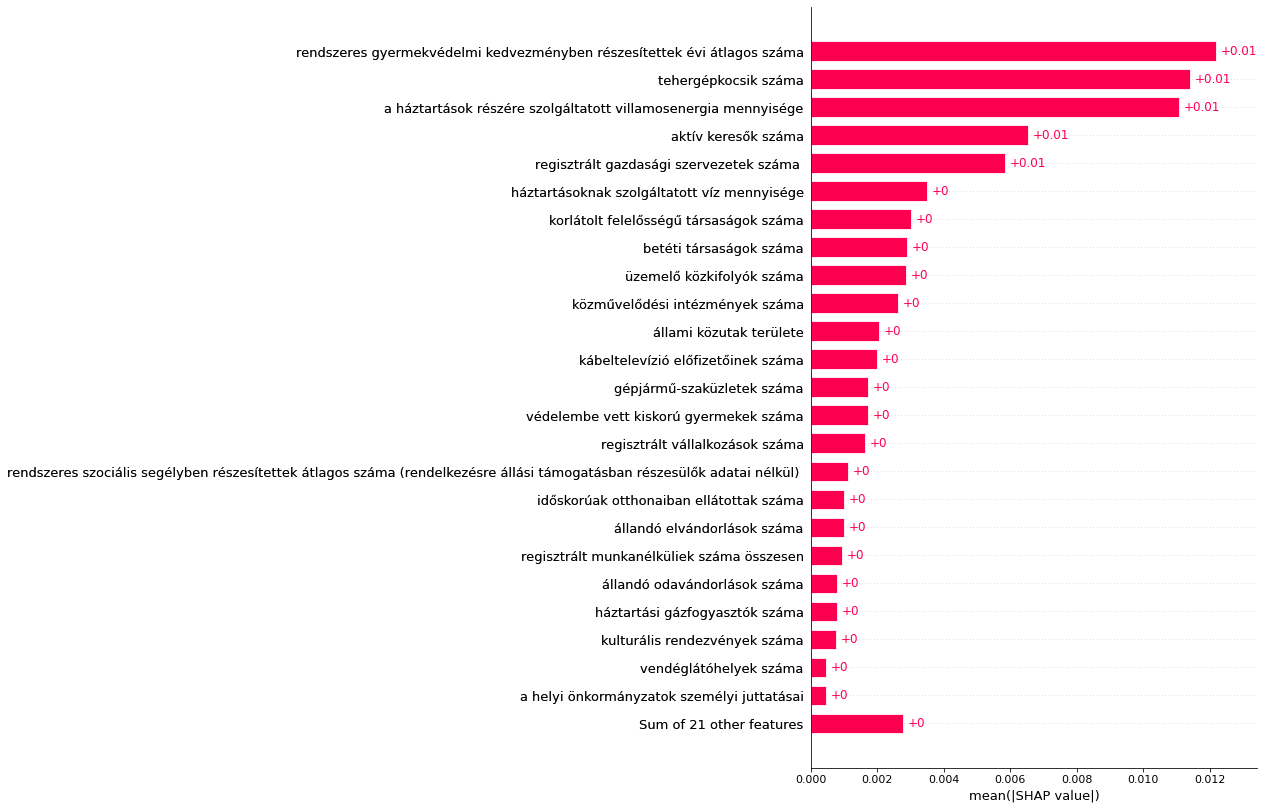

In [ ]:
shap.plots.bar(shap_values_sok_valt, max_display=25)

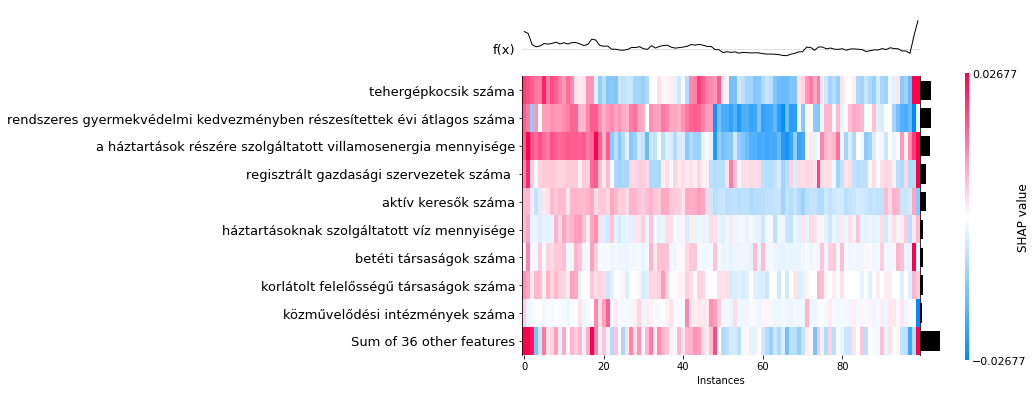

In [ ]:
shap.plots.heatmap(shap_values_sok_valt[100:200])

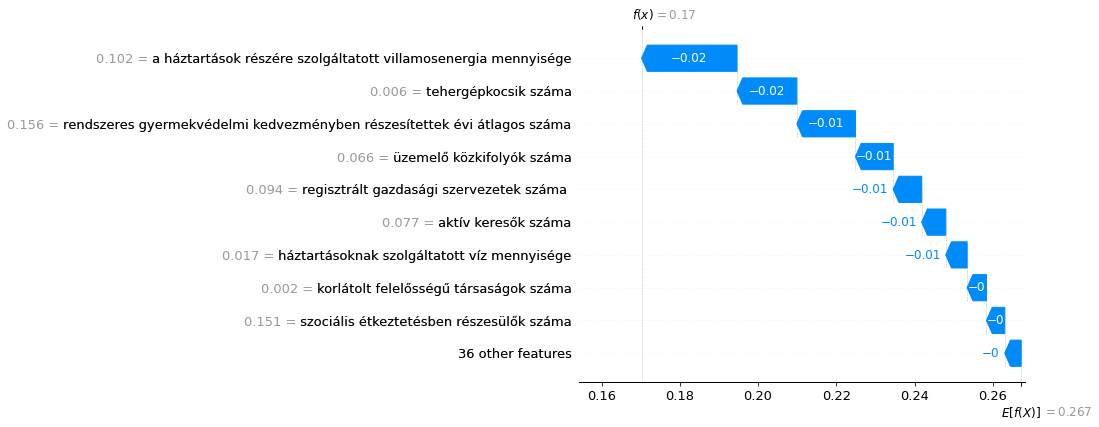

In [ ]:
shap.plots.waterfall(shap_values_sok_valt[170])

In [ ]:
shap.initjs()
explainer_sok_valt_tree = shap.TreeExplainer(xgb_model_sok_valt)
shap_values_sok_valt_tree = explainer_sok_valt_tree.shap_values(X_test_sok_valt)
def p(j):
    return(shap.force_plot(explainer_sok_valt_tree.expected_value, shap_values_sok_valt_tree[j,:], X_test_sok_valt.iloc[j,:]))
p(0)

The final prediction is  0.17024058


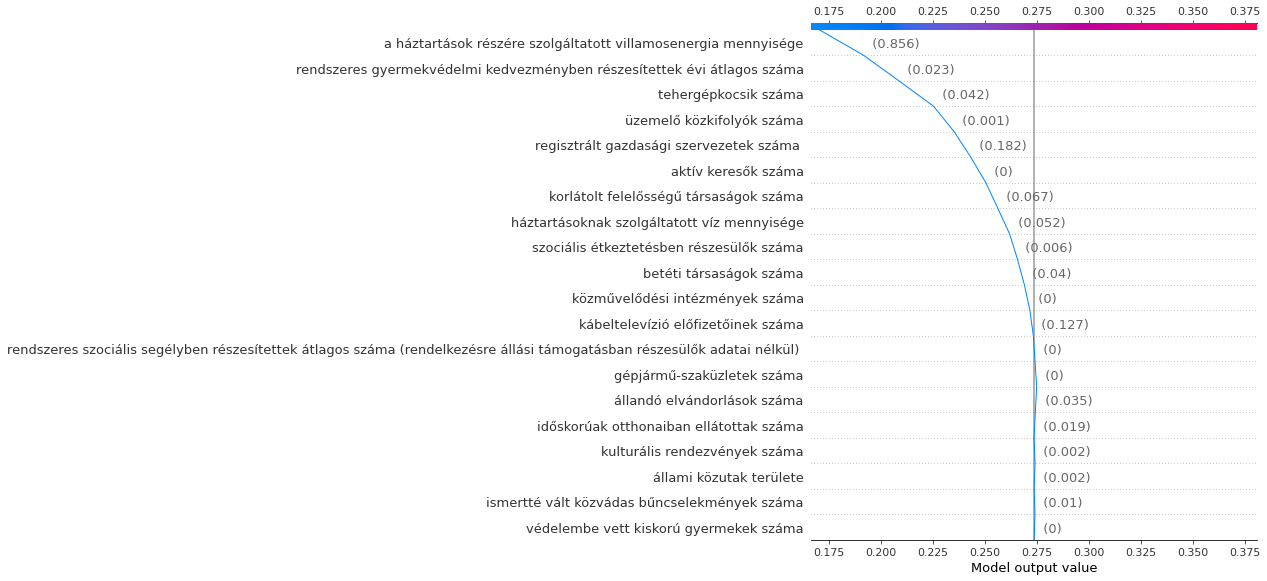

In [ ]:
expected_value = explainer_sok_valt_tree.expected_value
#print("The expected value is ", expected_value)
print("The final prediction is ", xgb_model_sok_valt.predict(X_test_sok_valt)[170])
shap_values_ex = explainer_sok_valt_tree.shap_values(X_test_sok_valt)[170]
shap.decision_plot(expected_value, shap_values_ex, X_test_sok_valt)

##**3. Effects of data transformations**

Before we made any further preprocessing steps, we investigated whether these steps influence the final Shapley values or not. We did this on the redwine dataset, but it's important to note that the results are different for different datasets. So in case someone intends to create new 'index' variables (based on their knowledge of a certain subject), it is advised to check which transformations have an effect on the rest of the variables as well as the new one. Normally when we keep a variable but multiply or scale it, that has no effect. But when we add a new variable that is the sum or multiplication of two other (that we also keep), that has an effect on all previous variables too (see below on the figures).

[15:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


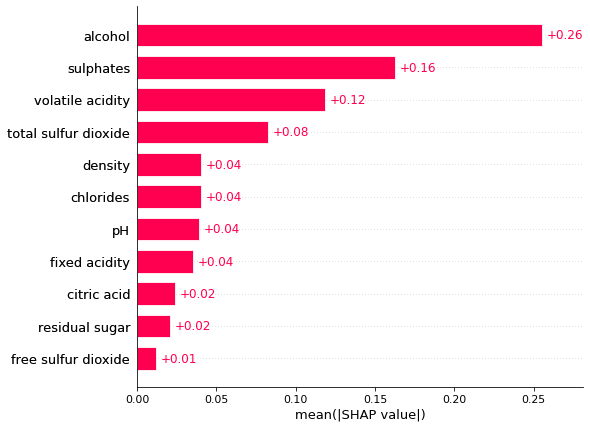

In [ ]:
# original data

df_wine = pd.read_csv('/content/winequality-red.csv')
df_wine_mod = df_wine.copy()
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


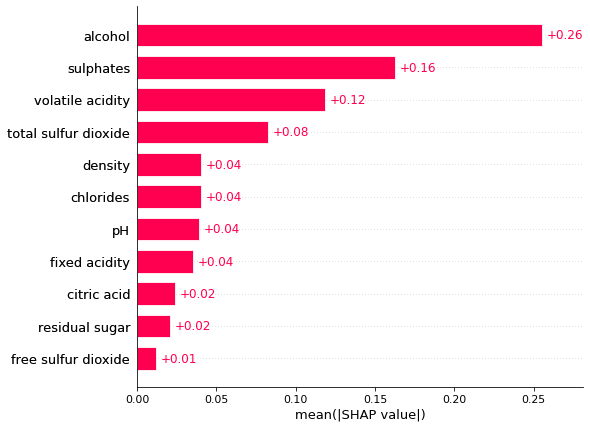

In [ ]:
# keeping the 'alcohol' variable but multiplying it by 2

df_wine = pd.read_csv('/content/winequality-red.csv')
df_wine_mod = df_wine.copy()
df_wine_mod['alcohol'] = df_wine_mod['alcohol'] * 2
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:11:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


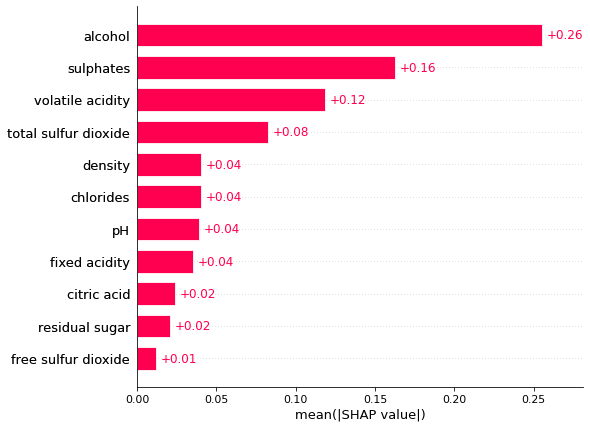

In [ ]:
# scaling the alcohol variable
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

df_wine_mod = df_wine.copy()
df_wine_mod[['alcohol']] =  mms.fit_transform(df_wine_mod[['alcohol']])
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:11:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


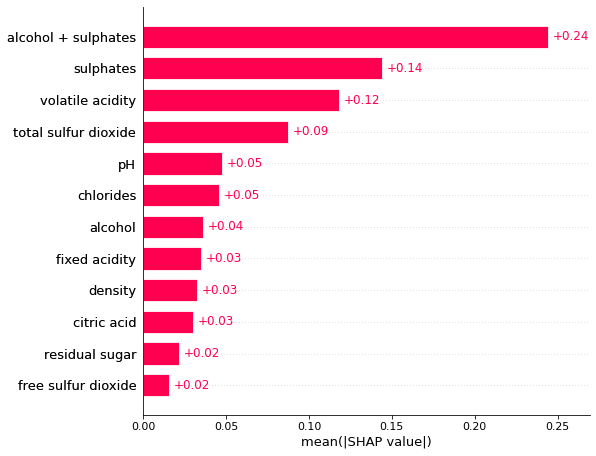

In [ ]:
# adding the originally 2 most important variables as a new one

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol + sulphates'] =  df_wine_mod['alcohol'] + df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol + sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


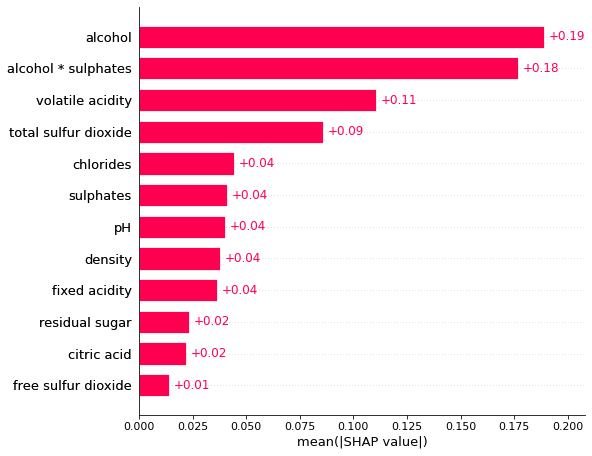

In [ ]:
# multiplying the originally 2 most important variables as a new one

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol * sulphates'] =  df_wine_mod['alcohol'] * df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol * sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


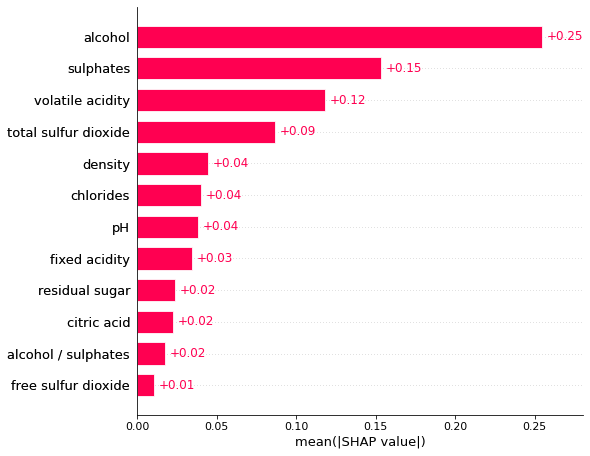

In [ ]:
# dividing the originally 2 most important variables as a new one

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol / sulphates'] =  df_wine_mod['alcohol'] / df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol / sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

## **4. Cohort Shapley**

Finally we cut the data by one variable (using our own domain knowledge or a decision tree to get the most homogenous cut) and do the same analysis on each set of datapoints. We wondered if we look at smaller, more similar sets do we get different results in terms of Shapley values and important variables. And the answer was yes in most cases. 

### Wine data

To do this we returned again to our wine dataset, where according to our simple decision tree, we cut by the alcohol variable.

In [ ]:
df_wine = pd.read_csv('/content/winequality-red.csv')

In [ ]:
df_wine['quality'] = df_wine['quality'].astype(int)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y_wine = df_wine['quality']
X_wine =  df_wine[features_wine]
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

[15:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
m_wine = DecisionTreeRegressor(max_leaf_nodes=2)
m_wine.fit(shap_values_wine.data, shap_values_wine.values)

DecisionTreeRegressor(max_leaf_nodes=2)

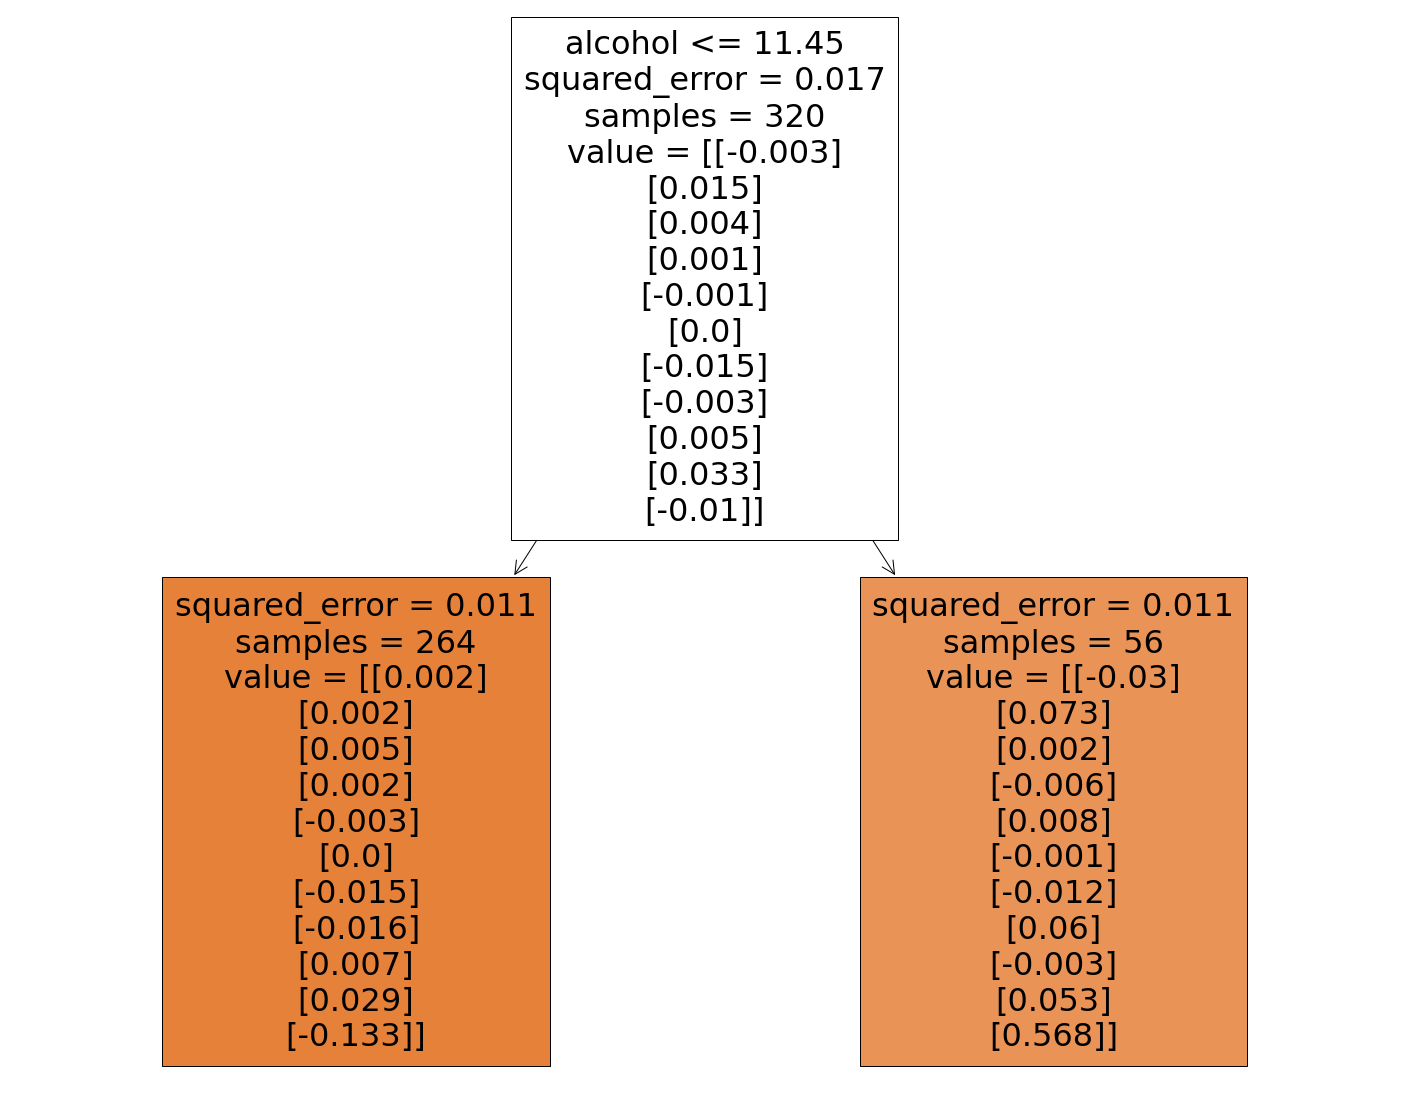

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m_wine, 
                   feature_names=features_wine,  
                   filled=True)

In [ ]:
explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

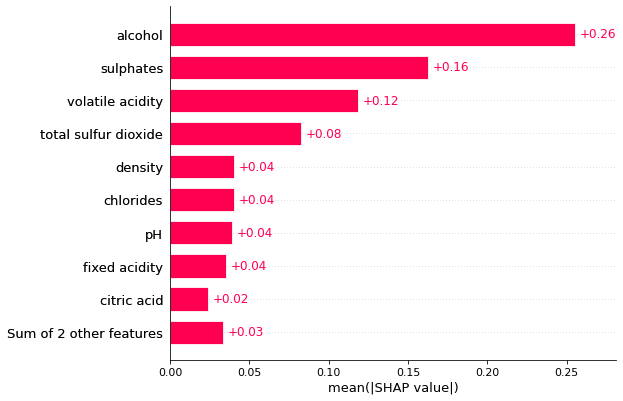

In [ ]:
shap.plots.bar(shap_values_wine, max_display=10)

In [ ]:
X_y_test_wine = X_test_wine.copy()
X_y_test_wine['quality'] = Y_test_wine
X_y_test_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
688,7.7,0.660,0.04,1.6,0.039,4.0,9.0,0.99620,3.40,0.47,9.4,5
961,7.1,0.560,0.14,1.6,0.078,7.0,18.0,0.99592,3.27,0.62,9.3,5
726,8.1,0.720,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1,6
537,8.1,0.825,0.24,2.1,0.084,5.0,13.0,0.99720,3.37,0.77,10.7,6
1544,8.4,0.370,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,7


In [ ]:
alcohol_less = X_y_test_wine[X_y_test_wine["alcohol"] < 11.4499]
alcohol_more = X_y_test_wine[X_y_test_wine["alcohol"] >= 11.4499]
alcohol_more.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1547,6.3,0.600,0.10,1.6,0.048,12.0,26.0,0.99306,3.55,0.51,12.1,5
142,5.2,0.340,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
1585,7.2,0.390,0.44,2.6,0.066,22.0,48.0,0.99494,3.30,0.84,11.5,6
1371,7.5,0.580,0.56,3.1,0.153,5.0,14.0,0.99476,3.21,1.03,11.6,6
1292,5.9,0.395,0.13,2.4,0.056,14.0,28.0,0.99362,3.62,0.67,12.4,6


In [ ]:
Y_cohort = alcohol_less['quality']
X_cohort =  alcohol_less[features_wine]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort, Y_cohort, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[15:11:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort = shap.Explainer(xgb_model_cohort)
shap_values_cohort = explainer_cohort(X_test_cohort)

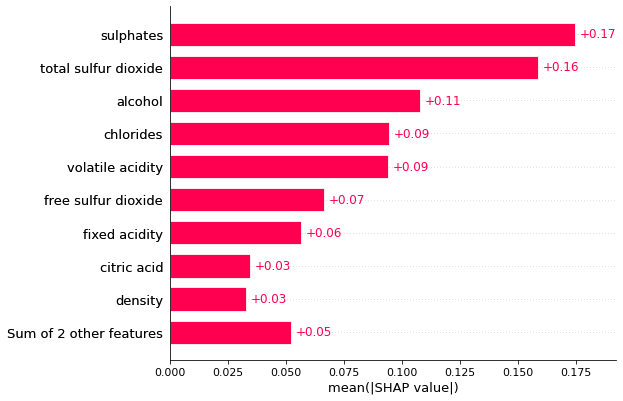

In [ ]:
shap.plots.bar(shap_values_cohort, max_display=10)

In [ ]:
Y_cohort = alcohol_more['quality']
X_cohort =  alcohol_more[features_wine]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort, Y_cohort, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[15:11:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort = shap.Explainer(xgb_model_cohort)
shap_values_cohort = explainer_cohort(X_test_cohort)

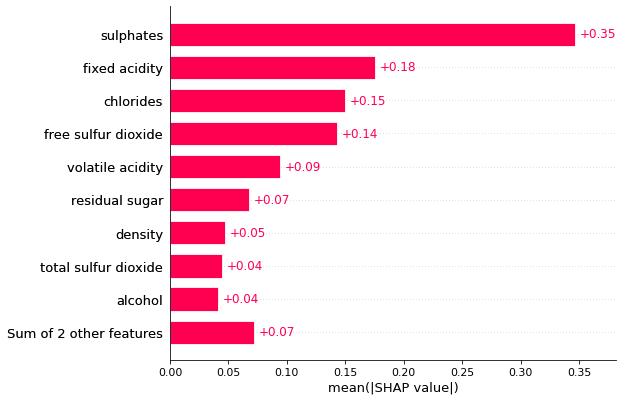

In [ ]:
shap.plots.bar(shap_values_cohort, max_display=10)

In both the high and low alcohol cases we found that alcohol itself loses of its importance and the previous second 'sulphates' rises to the top. This could be accounted to the fact that these datapoints are already grouped togethere based on their alcohol level.

### Residential data

As for the residential data we opted for the unemployment rate, which didn't result in notable changes, the main variables are pretty much the same but the order is slightly different.

In [ ]:
munkanelkuliseg_less = cross_all[cross_all["regisztrált munkanélküliek száma összesen"] < 0.15]
munkanelkuliseg_more = cross_all[cross_all["regisztrált munkanélküliek száma összesen"] >= 0.15]
munkanelkuliseg_less.head()

label,a helyi önkormányzatok saját folyó bevételei,a háztartások részére szolgáltatott villamosenergia mennyisége,egy éven túl nyilvántartott álláskeresők száma összesen,egyéni gazdaságok száma,háztartási gázfogyasztók száma,háztartásoknak szolgáltatott víz mennyisége,időskorúak járadékára felhasznált összeg,korlátolt felelősségű társaságok száma,kábeltelevízió előfizetőinek száma,regisztrált munkanélküliek száma összesen,regisztrált vállalkozások száma,rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma,rendszeres szociális segélyben részesítettek átlagos száma,személygépkocsik száma,önkormányzati kiépített út és köztér hossza,üzemelő közkifolyók száma
geoname,,,,,,,,,,,,,,,,
Aba,28.725931,0.926401,0.009628,0.090715,0.262516,0.026744,0.180573,0.014549,0.128156,0.056055,0.105263,0.093710,0.004279,0.226786,0.003209,0.000428
Abaliget,24.957192,1.316781,0.015411,0.056507,0.000000,0.034247,0.000000,0.029110,0.018836,0.099315,0.159247,0.094178,0.010274,0.330479,0.013699,0.003425
Abasár,86.654168,1.375349,0.018748,0.122058,0.349023,0.032708,0.129637,0.023135,0.166733,0.060630,0.254487,0.040686,0.002792,0.378141,0.004787,0.001596
Abaújkér,22.948350,0.862267,0.030129,0.124821,0.170732,0.018651,0.000000,0.011478,0.071736,0.114778,0.096126,0.175036,0.011478,0.164993,0.017217,0.048780
Abaújlak,12.759124,0.496350,0.014599,0.043796,0.000000,0.007299,0.000000,0.021898,0.000000,0.058394,0.160584,0.087591,0.007299,0.204380,0.007299,0.087591


In [ ]:
feature_names = list(cross_all.columns)
feature_names.pop(-3)

'személygépkocsik száma'

In [ ]:
Y_cohort_less = munkanelkuliseg_less['személygépkocsik száma']
X_cohort_less =  munkanelkuliseg_less[feature_names]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[15:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

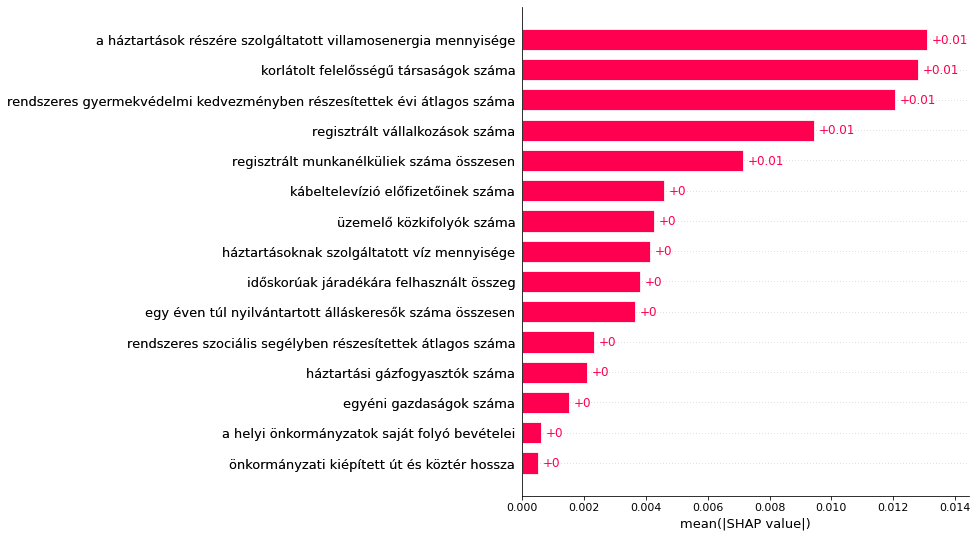

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

In [ ]:
Y_cohort_more = munkanelkuliseg_more['személygépkocsik száma']
X_cohort_more =  munkanelkuliseg_more[feature_names]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[15:11:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

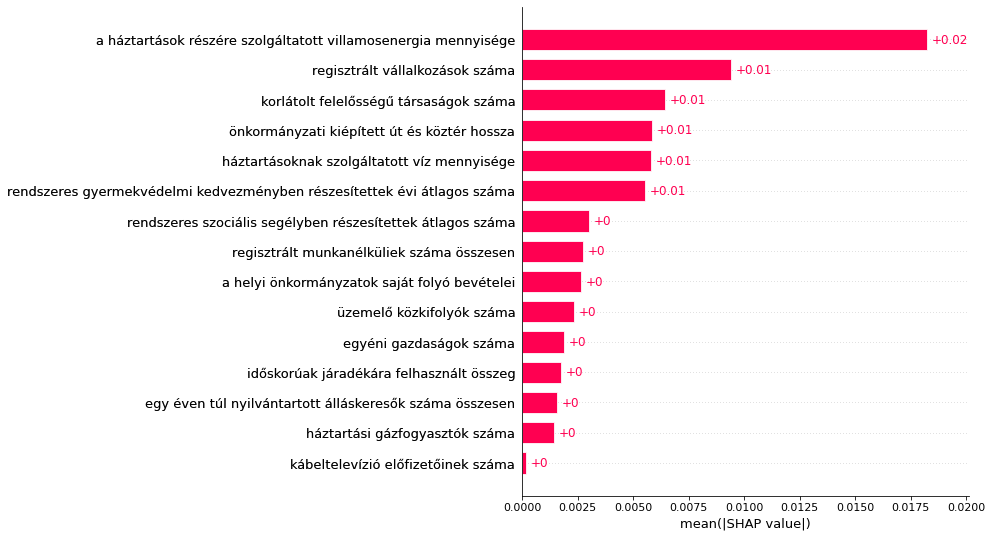

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

### Medical data

The final dataset was a medical one with breast cancer data. Here we had a classification task and we used our own domain knowledge to cut at radius and texture as well as a decision tree to use concave points as a cut.

In [ ]:
wdbc_feature_names=['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal dimension_se', 'radius_wr', 'texture_wr', 'perimeter_wr', 'area_wr', 'smoothness_wr', 'compactness_wr', 'concavity_wr', 'concave points_wr', 'symmetry_wr', 'fractal dimension_wr']

In [ ]:
bc_data = pd.read_csv('/content/wdbc.data',names=wdbc_feature_names, index_col=0)
bc_data.head()

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_wr,texture_wr,perimeter_wr,area_wr,smoothness_wr,compactness_wr,concavity_wr,concave points_wr,symmetry_wr,fractal dimension_wr
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
bc_data_mean = bc_data.iloc[:, :11]

In [ ]:
bc_data_mean.head()

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal dimension_mean
ID,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [ ]:
from xgboost import XGBClassifier

In [ ]:
features_bc = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
            'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal dimension_mean']
Y = bc_data_mean['Diagnosis']
X =  bc_data_mean[features_bc]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, Y_train)

XGBClassifier(random_state=42)

In [ ]:
explainer_bc = shap.Explainer(xgb_model, X_train)
shap_values_bc = explainer_bc(X_test)

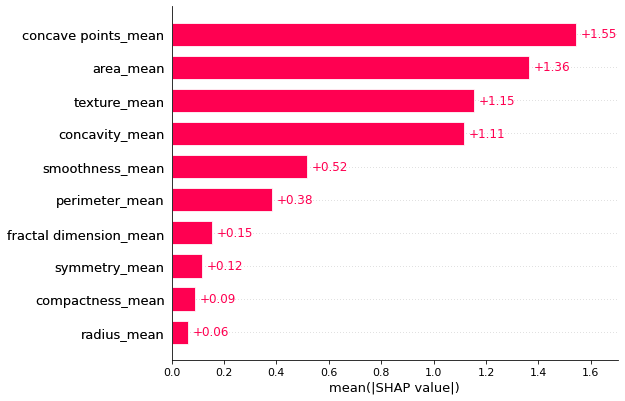

In [ ]:
shap.plots.bar(shap_values_bc, max_display=15)

Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


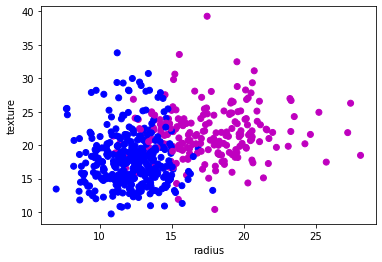

In [ ]:
radius_l = list(bc_data_mean['radius_mean'])
texture_l = list(bc_data_mean['texture_mean'])

plt.scatter(radius_l, texture_l, c=list(bc_data_mean['Diagnosis']))

plt.xlabel('radius')
plt.ylabel('texture')
plt.show()

Here we can see that the datapoints seperate well by the radius variable as at around 15 there's a change in the target variable value.

Radius

So we cut at 15 to find the most drastic change so far, in the above 15 case most variables fell a lot, especially concave points which went from most important to 0 effect at all.

In [ ]:
radius_less = bc_data_mean[bc_data_mean["radius_mean"] < 15]
radius_more = bc_data_mean[bc_data_mean["radius_mean"] >= 15]
radius_less.head()

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal dimension_mean
ID,,,,,,,,,,,
84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.24140,0.10520,0.2597,0.09744
843786,M,12.45,15.70,82.57,477.1,0.1278,0.1700,0.15780,0.08089,0.2087,0.07613
84458202,M,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451
844981,M,13.00,21.82,87.50,519.8,0.1273,0.1932,0.18590,0.09353,0.2350,0.07389
84501001,M,12.46,24.04,83.97,475.9,0.1186,0.2396,0.22730,0.08543,0.2030,0.08243


In [ ]:
Y_cohort_less = radius_less['Diagnosis']
X_cohort_less =  radius_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

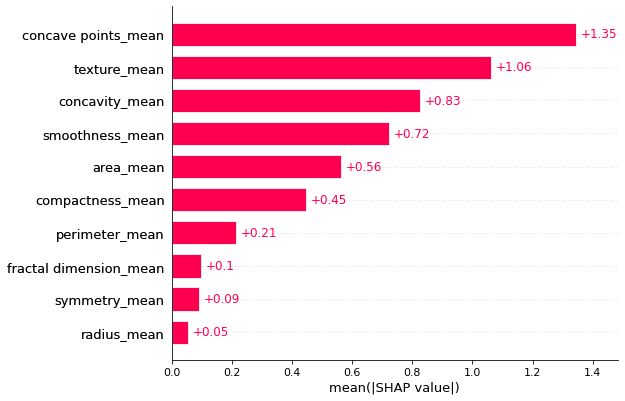

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

In [ ]:
Y_cohort_more = radius_more['Diagnosis']
X_cohort_more =  radius_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

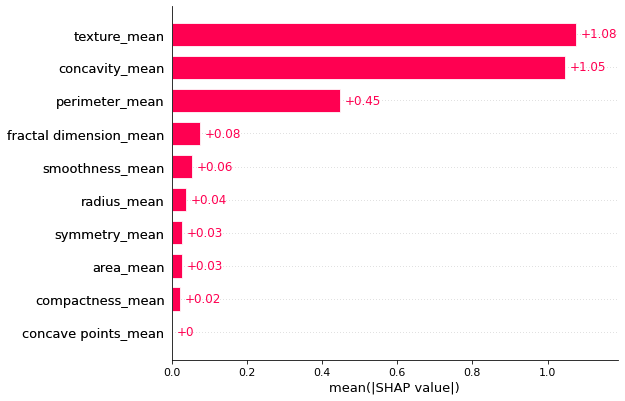

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

Texture

We used 15 for texture as well and experienced similar results, in one case multiple variables lost all their importance.

In [ ]:
texture_less = bc_data_mean[bc_data_mean["texture_mean"] < 15]
texture_more = bc_data_mean[bc_data_mean["texture_mean"] >= 15]
texture_less.head()

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal dimension_mean
ID,,,,,,,,,,,
842302,M,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
84358402,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766
8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905
8511133,M,15.340,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032


In [ ]:
Y_cohort_more = texture_more['Diagnosis']
X_cohort_more =  texture_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

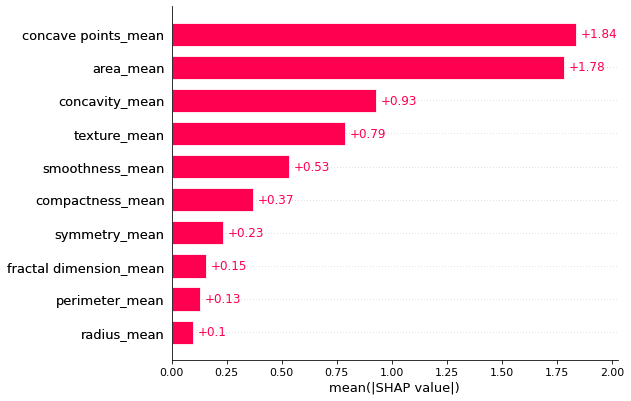

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

In [ ]:
Y_cohort_less = texture_less['Diagnosis']
X_cohort_less =  texture_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

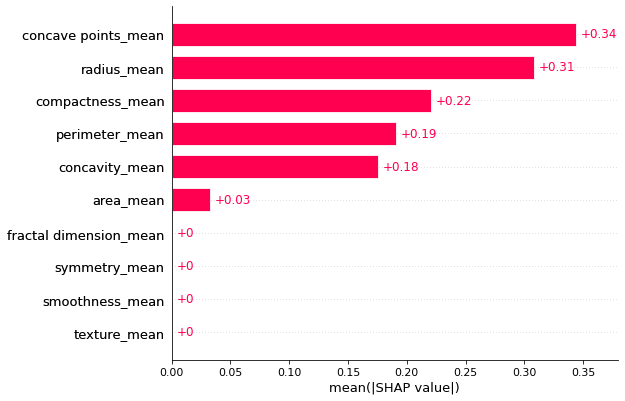

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

Decision tree

Our decision tree suggested the originally most important concave points as a cutting variable which brought the least change, the importance lists remained mostly the same.

In [ ]:
m_bc = DecisionTreeRegressor(max_leaf_nodes=2)
m_bc.fit(shap_values_bc.data, shap_values_bc.values)

DecisionTreeRegressor(max_leaf_nodes=2)

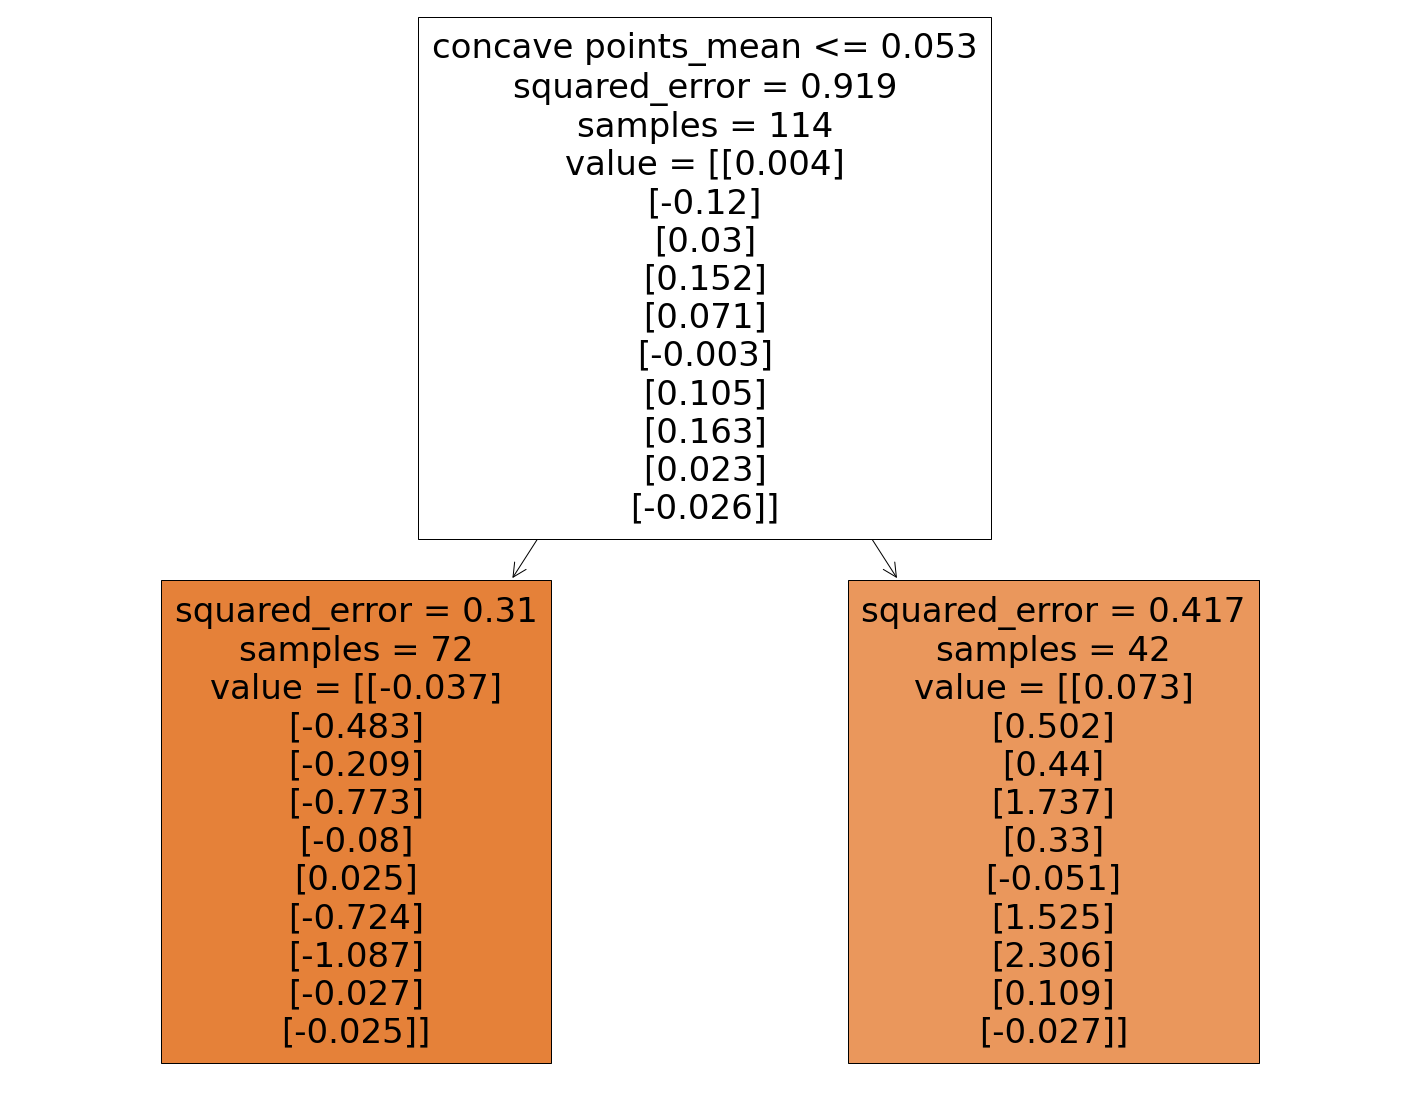

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m_bc, 
                   feature_names=features_bc,  
                   filled=True)

In [ ]:
concave_points_less = bc_data_mean[bc_data_mean["concave points_mean"] < 0.053]
concave_points_more = bc_data_mean[bc_data_mean["concave points_mean"] >= 0.053]
concave_points_less.head()

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal dimension_mean
ID,,,,,,,,,,,
845636,M,16.020,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697
848406,M,14.680,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,0.05922
8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766
8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811
8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905


In [ ]:
Y_cohort_more = concave_points_more['Diagnosis']
X_cohort_more =  concave_points_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

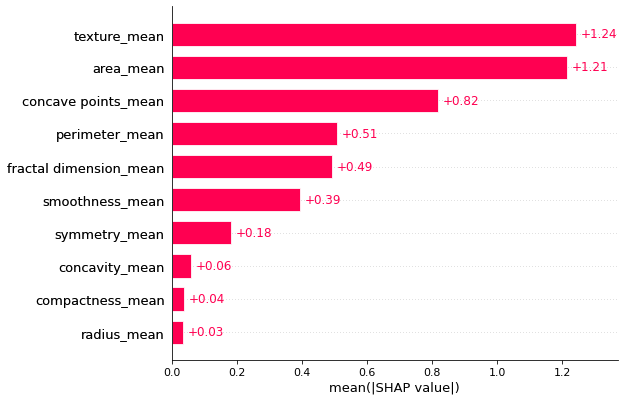

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

In [ ]:
Y_cohort_less = concave_points_less['Diagnosis']
X_cohort_less =  concave_points_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

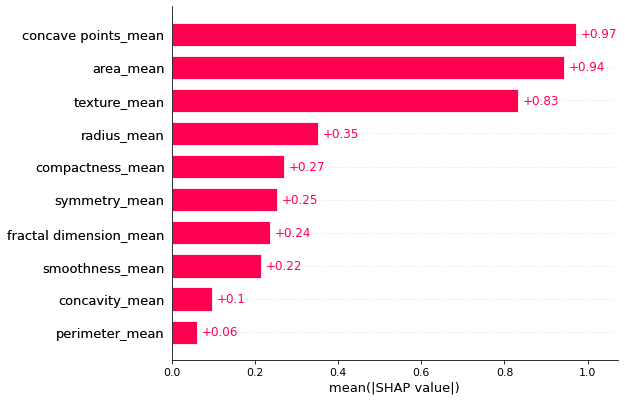

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)